In [1]:
#type = Ignore
#Importing packages
import torch
import torch.nn as nn
import torch.optim as optim
from AEModel import AE, MyDataset
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


# Reading Dataset

In [2]:
#Read files
gene_df= pd.read_csv("../../data/master_gene_df.csv",encoding = "UTF-8")


In [3]:
#type(gene_df.iloc[:,1:].shape[1])
gene_df.iloc[:,1:].head()

,TSPYL1,TRIM40,PCGF2,GLT8D2,MLKL,TRPC1,NOP14,PTK7,SAAL1,LRRC27,...,DHX34,XAGE1B,ARL8A,KCTD8,SLX1B,CPNE6,XYLB,PKN3,RGS1,PGK1
0,24.4909,0.0,21.6829,6.5735,11.8354,4.3273,17.0597,76.0102,13.5971,4.1564,...,13.1412,0.0000,114.5090,0.0000,0.0000,0.0000,3.3251,12.6058,84.0652,515.9193
1,12.3660,0.0,24.3977,12.3956,6.7753,3.4088,26.2333,35.2884,11.8437,1.0874,...,7.5863,0.1099,93.0715,0.3294,0.0000,0.0065,2.6886,11.6752,82.8888,1444.9458
2,41.5962,0.0,22.0650,5.2642,4.2537,0.8289,25.3952,64.0538,34.0402,0.9742,...,28.4462,0.0000,82.7308,0.0277,0.1222,0.0000,4.2784,7.2688,39.6819,632.6572
3,30.8982,0.0,14.7856,6.6122,5.0003,0.9631,30.4176,69.6955,33.3931,0.7268,...,20.8353,0.0000,168.9003,0.0000,0.0229,0.0471,7.0244,15.3454,26.6279,682.4480
4,14.1942,0.0,6.5414,5.0653,9.2886,0.9809,30.6175,83.9273,10.7675,2.1584,...,15.3766,0.0000,106.8909,0.0000,0.0000,0.0414,1.1573,3.3286,154.2987,436.9842


In [4]:
# DataLoader is used to load the dataset for training
pd_train_dataset, pd_test_dataset = train_test_split(gene_df.iloc[:,1:], test_size=0.2)

X_train_sc = StandardScaler().fit_transform(pd_train_dataset)

X_test_sc = StandardScaler().fit_transform(pd_test_dataset)

X_full_sc = StandardScaler().fit_transform(gene_df.iloc[:,1:])

In [5]:
data_train = MyDataset(X_train_sc)
data_test = MyDataset(X_test_sc)
data_full = MyDataset(X_full_sc)

In [6]:
train_loader=DataLoader(data_train, batch_size=50, shuffle=False)
test_loader = DataLoader(data_test, batch_size=50)

In [7]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape = len(X_train_sc[0])).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

In [8]:
losses_train = []
losses_val = []

epochs=300
for epoch in range(epochs):
    model.train()
    loss = 0
    for batch_features in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        lol, outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    losses_train.append(loss)


    #For Valid Loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            code, outputs = model(batch)
            loss_val =criterion(outputs, batch)
            val_loss += loss_val.item()

    val_loss = val_loss / len(test_loader)
    losses_val.append(val_loss)


    # display the epoch training loss
    print("epoch : {}/{}, train_loss = {:.6f}".format(epoch + 1, epochs, loss))
    print("epoch : {}/{}, val_loss = {:.6f}".format(epoch + 1, epochs, val_loss))

epoch : 1/300, train_loss = 1.649744
epoch : 1/300, val_loss = 1.873881
epoch : 2/300, train_loss = 1.269048
epoch : 2/300, val_loss = 1.302953
epoch : 3/300, train_loss = 1.116839
epoch : 3/300, val_loss = 1.110397
epoch : 4/300, train_loss = 1.018360
epoch : 4/300, val_loss = 1.012367
epoch : 5/300, train_loss = 0.947758
epoch : 5/300, val_loss = 0.953015
epoch : 6/300, train_loss = 0.895796
epoch : 6/300, val_loss = 0.918318
epoch : 7/300, train_loss = 0.855828
epoch : 7/300, val_loss = 0.917071
epoch : 8/300, train_loss = 0.825374
epoch : 8/300, val_loss = 0.915940
epoch : 9/300, train_loss = 0.801172
epoch : 9/300, val_loss = 0.864377
epoch : 10/300, train_loss = 0.773434
epoch : 10/300, val_loss = 0.870696
epoch : 11/300, train_loss = 0.743416
epoch : 11/300, val_loss = 0.828268
epoch : 12/300, train_loss = 0.713683
epoch : 12/300, val_loss = 0.807799
epoch : 13/300, train_loss = 0.687650
epoch : 13/300, val_loss = 0.778897
epoch : 14/300, train_loss = 0.664801
epoch : 14/300, va

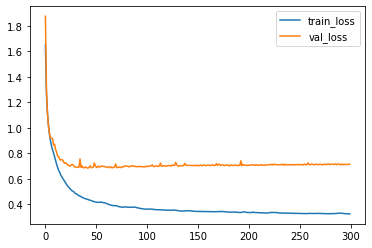

In [10]:
plt.plot(losses_train, label = 'train_loss')
plt.plot(losses_val, label = 'val_loss')
plt.legend()
plt.savefig("../../Figures/AE_GENE_300.png", dpi = 400)

In [11]:
# Full Gene Autoencoder Taining

data_full = MyDataset(X_full_sc)
full_loader = DataLoader(data_full, batch_size=50)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AE(input_shape = len(X_full_sc[0])).to(device)
optimizer = optim.Adam(model.parameters(),lr=1e-3)
criterion = nn.MSELoss()



In [12]:
losses_train_final = []

epochs=90
for epoch in range(epochs):
    model.train()
    loss = 0
    for batch_features in full_loader:
        batch_features = batch_features.to(device)
        
        optimizer.zero_grad()
        
        code, outputs = model(batch_features)
        
        train_loss = criterion(outputs, batch_features)
        
        train_loss.backward()
        
        optimizer.step()
        
        loss += train_loss.item()
    
    loss = loss / len(train_loader)
    losses_train_final.append(loss)

    print("epoch : {}/{}, train_loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/90, train_loss = 2.046481
epoch : 2/90, train_loss = 1.586013
epoch : 3/90, train_loss = 1.415245
epoch : 4/90, train_loss = 1.300330
epoch : 5/90, train_loss = 1.217544
epoch : 6/90, train_loss = 1.153237
epoch : 7/90, train_loss = 1.103091
epoch : 8/90, train_loss = 1.062989
epoch : 9/90, train_loss = 1.029086
epoch : 10/90, train_loss = 0.998188
epoch : 11/90, train_loss = 0.969073
epoch : 12/90, train_loss = 0.943585
epoch : 13/90, train_loss = 0.912189
epoch : 14/90, train_loss = 0.891617
epoch : 15/90, train_loss = 0.870798
epoch : 16/90, train_loss = 0.852509
epoch : 17/90, train_loss = 0.837566
epoch : 18/90, train_loss = 0.822329
epoch : 19/90, train_loss = 0.807550
epoch : 20/90, train_loss = 0.785314
epoch : 21/90, train_loss = 0.770507
epoch : 22/90, train_loss = 0.760360
epoch : 23/90, train_loss = 0.752065
epoch : 24/90, train_loss = 0.739644
epoch : 25/90, train_loss = 0.731057
epoch : 26/90, train_loss = 0.720784
epoch : 27/90, train_loss = 0.712438
epoch : 28

In [13]:
data = torch.tensor(X_full_sc,dtype=torch.float32)
model.eval()
with torch.no_grad():
    out,out2 = model(data)

In [14]:
latent_df = pd.DataFrame(out)
latent_df.insert(0,'file_name',gene_df['file_name'])
latent_df

,file_name,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,126,127
0,5faf8a12-a2aa-44f1-b099-02106766ec94,-0.582455,-0.701758,-0.640041,-0.651243,-0.515404,-0.495131,-0.517379,0.588646,1.863894,...,-0.363178,-0.542616,-0.228780,-0.752959,0.219008,0.072883,-0.592596,1.412789,0.309494,-0.453034
1,6855a406-c085-45c7-b789-981786f0c775,0.524985,-0.701758,-0.570597,-0.651243,-0.502745,-0.567748,-0.517379,0.496048,0.408932,...,0.098739,-0.278106,-0.617647,-0.752959,-0.714272,-0.146005,-0.592596,-0.440188,-0.172580,-0.453034
2,e2445ad6-2a6a-4ec3-84d8-93cc3c180a58,-0.582455,-0.701758,-0.708642,1.080668,-0.108780,-0.567748,-0.517379,0.522610,1.562211,...,-0.774314,-0.542616,-0.617647,0.659960,-0.714272,-0.541447,-0.592596,-0.440188,-0.563508,-0.453034
3,cded92df-9367-4ee5-930c-6c87bf2c8eb0,-0.582455,-0.701758,-0.708642,-0.651243,0.383334,-0.567748,-0.517379,0.747962,-0.877069,...,-0.653396,-0.542616,-0.617647,-0.439350,-0.714272,-0.541447,-0.368792,-0.440188,-0.563508,-0.453034
4,4b167e70-e4e6-47f7-9fe9-11cf20f0d442,-0.582455,-0.701758,-0.575235,-0.361519,-0.559405,-0.049738,-0.517379,-0.508362,-0.064147,...,0.419900,-0.542616,-0.577881,0.292234,0.232081,-0.541447,-0.592596,0.329495,-0.563508,-0.453034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,1120d776-47df-4f72-862e-427d3c44dd43,-0.582455,3.368099,-0.708642,-0.651243,2.451207,-0.567748,2.684066,-0.508362,1.334759,...,2.597004,2.762867,-0.617647,-0.741728,-0.714272,-0.541447,-0.592596,1.133704,-0.563508,3.877753
950,f9cd1c16-3be3-415c-8d7b-9249c3b1c7fa,-0.582455,1.134392,-0.708642,-0.651243,-0.559405,-0.567748,-0.058601,1.706750,1.294286,...,-0.774314,-0.542616,-0.617647,-0.752959,-0.714272,-0.541447,-0.592596,-0.440188,-0.563508,-0.453034
951,218eb2f2-24b1-4e41-9071-26ed97a2edc1,-0.582455,-0.701758,-0.385373,-0.651243,-0.559405,0.202025,-0.517379,-0.508362,-0.877069,...,-0.774314,-0.465337,-0.617647,-0.752959,1.403707,0.613643,-0.592596,-0.440188,2.280259,0.142929
952,978939fa-a27f-46ff-9120-7a43e3588b28,1.776533,-0.701758,3.526804,3.228420,2.415606,2.524337,3.241502,-0.508362,-0.877069,...,0.809077,2.943850,3.043370,-0.244963,-0.714272,2.856963,1.960175,1.890877,-0.563508,2.132638


In [15]:
latent_df.to_csv("../../data/gene_df_128.csv", index=False)